In [2]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms
import torch.nn.functional as func
#torch.manual_seed(50)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(torch.__version__, torchvision.__version__)

print (torch.cuda.get_device_name(device='cuda:0'))

1.9.0+cu111 0.10.0+cu111


RuntimeError: ignored

In [3]:
# dst = datasets.CIFAR100("~/.torch", download=True)
# dst = datasets.MNIST("~/.torch", download=True)

tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

def label_to_onehot(target, num_classes=10):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

Running on cpu


In [4]:
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.5, 0.5)
#         nn.init.xavier_uniform_(m.weight.data)
#     if hasattr(m, "bias"):
#         #m.bias.data.uniform_(-0.5, 0.5)
#         #nn.init.xavier_uniform(m.bias.data)
#         m.bias.data.fill_(0)



# class LeNet(nn.Module):

#     def __init__(self):

#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, kernel_size=5,stride=2)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=2)
#         self.fc1 = nn.Linear(16*5*5, 256)
#         self.fc2 = nn.Linear(256, 120)
#         self.fc3 = nn.Linear(120, 106)

#     def forward(self, x):
#         #x = func.relu(self.conv1(x))
#         x = func.sigmoid(self.conv1(x))
#         #x = func.max_pool2d(x, 2)
#         #x = func.relu(self.conv2(x))
#         x = func.sigmoid(self.conv2(x))
#         #x = func.max_pool2d(x, 2)
#         x = x.view(x.size(0), -1)
#         #x = func.relu(self.fc1(x))
#         x = func.sigmoid(self.fc1(x))
#         #x = func.relu(self.fc2(x))
#         x = func.sigmoid(self.fc2(x))
#         x = self.fc3(x)
#         return x

    
    
# def weights_init(m):
#     if hasattr(m, "weight"):
#         m.weight.data.uniform_(-0.3, 0.3)
#     if hasattr(m, "bias"):
#         m.bias.data.uniform_(-0.3, 0.3)

torch.manual_seed(50)

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
def weights_init_dropout(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.1, 0.1)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.1, 0.1)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        #act = nn.Tanh
        #act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
                nn.Linear(768, 106),
                 nn.Dropout(p=0.0)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out

    

net = LeNet().to(device)
net.apply(weights_init)


# class LeNet_att(nn.Module):
#     def __init__(self):
#         super(LeNet_att, self).__init__()
#         act = nn.Sigmoid
#         #act = nn.Tanh
#         #act = nn.ReLU
#         self.body = nn.Sequential(
#             nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#             nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
#             act(),
#         )
#         self.fc = nn.Sequential(
#                 nn.Linear(768, 106)
#         )
        
#     def forward(self, x):
#         out = self.body(x)
#         out = out.view(out.size(0), -1)
#         # print(out.size())
#         out = self.fc(out)
#         return out

# net_att = LeNet_att().to(device)
# net_att.apply(weights_init_dropout)
    
#criterion = cross_entropy_for_onehot
criterion = nn.CrossEntropyLoss()

In [5]:
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
lfw_people=fetch_lfw_people(min_faces_per_person=55,color=True,slice_=(slice(61,189),slice(61,189)),resize=0.25)
x=lfw_people.images
y=lfw_people.target

target_names=lfw_people.target_names
n_classes=target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25,shuffle=False)


# #two people
# X_train_two = []
# y_train_two = []
# X_test_two = []
# y_test_two = []
# for ct_d in range(X_train.shape[0]):
#     if  y_train[ct_d] == 6:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_train_two.append(X_train[ct_d])
#         y_train_two.append(1)
        
# for ct_d in range(X_test.shape[0]):
#     if  y_train[ct_d] == 6:        
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(0)
#     if  y_train[ct_d] == 9:
#         X_test_two.append(X_test[ct_d])
#         y_test_two.append(1)
        
# X_train = np.asarray(X_train_two)    
# X_test = np.asarray(X_test_two)  
# y_train = np.asarray(y_train_two)  
# y_test = np.asarray(y_test_two)  

print (X_train.shape)
print (X_test.shape)

         
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
#X_train = torch.transpose
#X_train = X_train.astype('float32')
X_train /= 255.0
X_test /= 255.0

 


x_train = torch.FloatTensor(X_train).to(device)
x_train = x_train.transpose(2,3).transpose(1,2)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
x_test = x_test.transpose(2,3).transpose(1,2)
y_test = torch.LongTensor(y_test).to(device)


training = data.TensorDataset(x_train,y_train)

testing = data.TensorDataset(x_test,y_test)

dst_tensor=training

criterion_train = nn.CrossEntropyLoss()
optimizer_train = optim.Adam(net.parameters(),lr=0.01)#,momentum=0.9)
trainloader = torch.utils.data.DataLoader(training,batch_size=32, shuffle=True)

(1052, 32, 32, 3)
(351, 32, 32, 3)


In [5]:
iter_ = 0


for epoch in range(0):

    for i,data in enumerate(trainloader,0):
   
        #if epoch>=1:
        if i==1:
            #break
            iter_=iter_+1
            #print (iter_)
            inputs,label = data

            inputs,label =  Variable(inputs),Variable(label) 

            optimizer_train.zero_grad()


            outputs_benign=net(inputs)
            #outputs_benign = F.softmax(outputs_benign, dim=-1)
            #print (outputs_benign[0])


            loss_benign =  criterion_train(outputs_benign,label)

            #print("loss computed")
            loss_benign.backward()
            #print("loss BP")
            optimizer_train.step()

            #if i%2000==0:
            print (loss_benign.item())
            #torch.save(net.state_dict(),'./LFW_net.pth')  
       
  
print ('fininshed training')
total = len(y_test)
acc =0.0
for ct in range(total):
    testing_data = tt(testing[ct][0].cpu())
    testing_data1 = tp(testing_data).to(device)
    testing_data2 = testing_data1.view(1, *testing_data1.size())
    y_pred = net(testing_data2)
    predicted = torch.argmax(y_pred)
  
    if predicted == y_test[ct]:
        acc=acc+1
accuracy = acc / total
print (accuracy)
print ('fininshed testing')


fininshed training
0.0
fininshed testing


torch.Size([1, 3, 32, 32])
torch.Size([1, 1])
tensor([[2]])
torch.Size([1, 106])


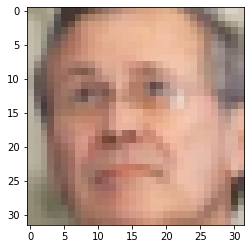

In [6]:

######### honest partipant #########
img_index = 26   #use img_index
dst_pil = tt(dst_tensor[img_index][0].cpu())   #use img_index

gt_data = tp(dst_pil).to(device)
gt_data = torch.unsqueeze(gt_data,0)

gt_label = dst_tensor[img_index][1].long().to(device) #use img_index
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=106)

plt.imshow(dst_pil)
#plt.savefig("./original/index_%s_label_%s"%(img_index,gt_label.item()))



batch =1  #
for bat in range(batch-1):
    dst_pil = tt(dst_tensor[img_index+1+bat][0].cpu())   #use img_index
    tmp = torch.unsqueeze(tp(dst_pil).to(device),0)
    #print(tmp.shape)
    gt_data = torch.cat((gt_data,tmp),0)
    
    gt_label_tmp = dst_tensor[img_index+1+bat][1].long().to(device) #use img_index
    gt_label_tmp = gt_label_tmp.view(1, )
    gt_label = torch.cat((gt_label,gt_label_tmp),0)
    gt_onehot_label = torch.cat((gt_onehot_label,label_to_onehot(gt_label_tmp, num_classes=106)),0)
    
    if gt_label_tmp ==60:
        print (bat)

    plt.imshow(dst_pil)
    #plt.savefig("./original/index_%s_label_%s"%(bat+1,gt_label_tmp.item()))
    
    #plt.title("Ground truth image")
    #print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

    
gt_label = torch.reshape(gt_label,(-1,1))    
print (gt_data.shape)
print (gt_label.shape)
print (gt_label)
print (gt_onehot_label.shape)

plt.imshow(tt(gt_data[0].cpu()),cmap='gray')
# plt.axis('off')
# plt.savefig("./attack_image/tifs")


# compute original gradient 
dy_dx = []
original_dy_dx=[]
original_pred = []
for item in range(batch):
    gt_data_single = torch.unsqueeze(gt_data[item],0)
    out = net(gt_data_single)
    #y = criterion(out, gt_onehot_label[item])
    y = criterion(out, gt_label[item])
    dy_dx = torch.autograd.grad(y, net.parameters(),retain_graph=True)
    original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
    original_dy_dx.append(original_dy_dx_tmp)
    out_tmp = out.detach().clone()
    original_pred.append(out_tmp)
    
    
    #dy_dx.append(torch.autograd.grad(y, net.parameters()))

    
    
# #FOR fully-connected model only
#     dw = net.body[0].weight
#     db = net.body[0].bias
#     dy_dw = torch.autograd.grad(y, dw,retain_graph=True)
#     dy_db = torch.autograd.grad(y, db,retain_graph=True)

#     print (dy_dw)
#     #print (dy_db.shape)

#     leak=dy_dw/dy_db

#     print (leak.shape)
    


# share the gradients with other clients
#original_dy_dx = list((_.detach().clone() for _ in dy_dx))


In [7]:
!pip install pytorch_msssim

In [8]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Dummy label is 10.
stolen label is 2.
24.49682236
3.00184131
0.73360270
0.21515797
0.07549518
0.02987635
0.01528255
0.00794433
0.00444805
0.00257468
0.00152389
0.00103170
0.00070490
0.00047305
0.00031818
0.00022716
0.00016974
0.00012658
0.00009106
0.00006609


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

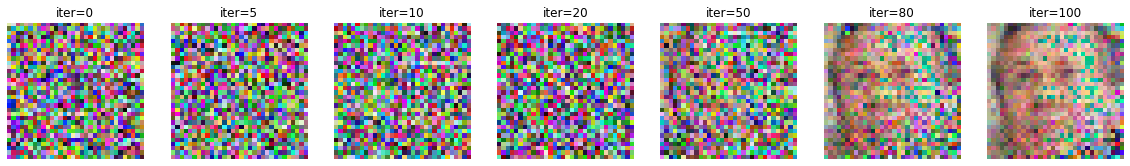

Dummy label is 100.
stolen label is 2.
9.48813534
0.05629564
0.01156241
0.00464651
0.00235786
0.00129207
0.00073852
0.00045361
0.00029436
0.00018480
0.00012380
0.00008860
0.00006430
0.00004755
0.00003635
0.00002738
0.00002103
0.00001610
0.00001265
0.00001009


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

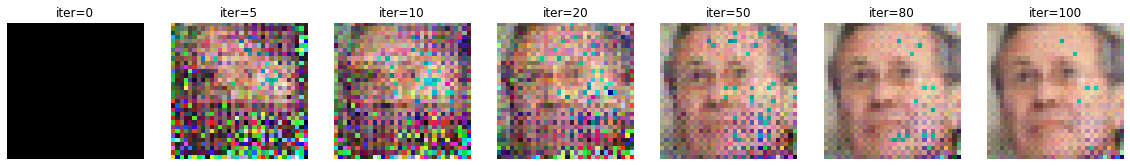

Dummy label is 31.
stolen label is 2.
2.81015301
0.08687782
0.02345723
0.00920804
0.00420848
0.00226371
0.00128298
0.00071266
0.00043624
0.00027641
0.00017957
0.00011959
0.00007960
0.00005529
0.00003867
0.00002646
0.00001833
0.00001315
0.00000978
0.00000716


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

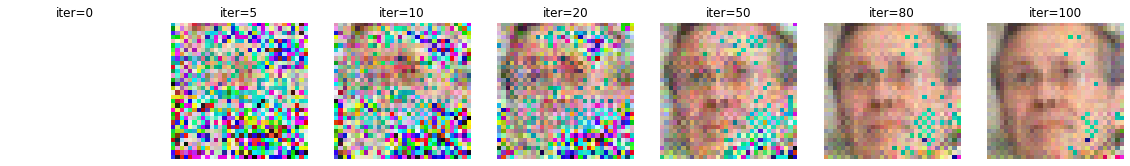

Dummy label is 29.
stolen label is 2.
2.58326292
0.02074867
0.00439851
0.00159367
0.00076155
0.00042221
0.00024159
0.00015070
0.00010002
0.00006742
0.00004430
0.00003121
0.00002156
0.00001501
0.00001061
0.00000830
0.00000646
0.00000497
0.00000393
0.00000306


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

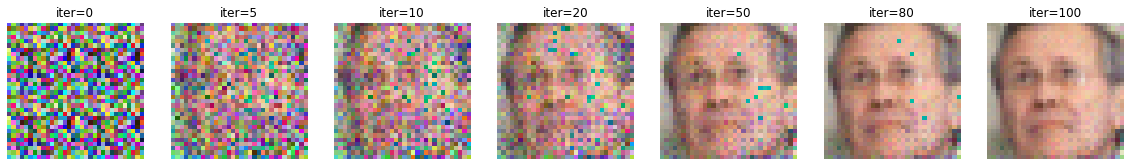

Dummy label is 11.
stolen label is 2.
2.68001366
0.02943539
0.00672899
0.00274150
0.00128283
0.00070184
0.00043555
0.00028222
0.00017998
0.00012524
0.00008352
0.00005768
0.00004071
0.00003003
0.00002202
0.00001680
0.00001272
0.00000989
0.00000770
0.00000591


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

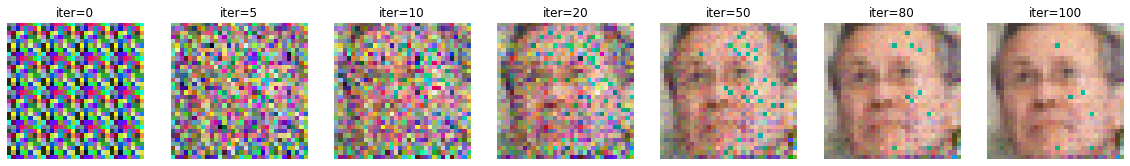

11.606288300000001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:210: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [9]:
# generate dummy data and label
import time
import torch.nn.functional as F
from pytorch_msssim import ssim
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import numpy as np
import cv2

#print (ssim(0.43*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),data_range=0).item())
#print (torch.dist(0.6*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),2).item())

plt.imshow(tt(gt_data[0].cpu()),cmap='gray')

mses = []
ssims = []

for item in range(1):
    start = time.clock()
    for rd in range(1):

        torch.manual_seed(200*rd)
        for ii in range(5):
        # all random dummy init
          dummy_data1 = torch.unsqueeze(torch.randn(gt_data[item].size()),0).to(device).requires_grad_(True)
          
          # all black dummy init
          dummy_data2 = torch.unsqueeze(torch.zeros(gt_data[item].size()),0).to(device).requires_grad_(True)
          
          # all white dummy init
          dummy_data3 = torch.unsqueeze(torch.ones(gt_data[item].size()),0).to(device).requires_grad_(True)

          
          #background = torch.unsqueeze(torch.zeros(gt_data[item].size()),0)
          #background[0,0,::] = 1
          #dummy_data = background.to(device).requires_grad_(True)
          ##dummy_data = (torch.unsqueeze(torch.randn(gt_data[item].size()),0)+background).to(device).requires_grad_(True)
          
          #surrogate = torch.unsqueeze(gt_data[item+1],0)
          #aaa = torch.rand([3,16,16])
          #surrogate[0,:,8:24,8:24] =aaa
          #dummy_data = surrogate.to(device).requires_grad_(True)    
          
          #dummy_data = torch.unsqueeze(gt_data[item+1],0).to(device).requires_grad_(True)
          
          #k = np.random.randint(0,95)
          #dummy_data = torch.unsqueeze(gt_data[k],0).to(device).requires_grad_(True)
          
          ## original uncommented dummy_data initialisation in the repo - looks like patterened i.e. quadrants of a grid are the same
          pat_1 = torch.rand([3,16,16])
          pat_2 = torch.cat((pat_1,pat_1),dim=1)
          pat_4 = torch.cat((pat_2,pat_2),dim=2)
          dummy_data4 = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)
          
          ## another dummy_data initialisation in the repo - even more patterened i.e. half-quadrants of a grid are the same
          aaa = torch.rand([3,8,8])
          bbb = torch.cat((aaa,aaa),dim=1)
          ccc = torch.cat((bbb,bbb),dim=1)
          ddd = torch.cat((ccc,ccc),dim=2)
          eee = torch.cat((ddd,ddd),dim=2)
          dummy_data5 = torch.unsqueeze(eee,dim=0).to(device).requires_grad_(True)
          
          #aaa = torch.rand([3,4,4])
          #bbb = torch.cat((aaa,aaa),dim=1)
          #ccc = torch.cat((bbb,bbb),dim=1)
          #ddd = torch.cat((ccc,ccc),dim=1)
          #eee = torch.cat((ddd,ddd),dim=2)
          #fff = torch.cat((eee,eee),dim=2)
          #ggg = torch.cat((fff,fff),dim=2)
          #dummy_data = torch.unsqueeze(ggg,dim=0).to(device).requires_grad_(True)
          initDataPossibilities = [dummy_data1,dummy_data2,dummy_data3,dummy_data4,dummy_data5]
          dummy_data = initDataPossibilities[ii]
          
          #dummy_data = plt.imread("./attack_image/replacement_69.png")
          #print (dummy_data.shape)
          #dummy_data = torch.FloatTensor(dummy_data).to(device)
          #dummy_data = dummy_data.transpose(2,3).transpose(1,2)
          
          dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)
          
          dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
          label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                  dim=-1).detach().reshape((1,)).requires_grad_(False)
          #print (original_dy_dx[item][-1].shape)
          #print (original_dy_dx[item][-1].argmin())
          
          #print (torch.sum(original_dy_dx[item][-2], dim=-1).argmin())
          
          plt.imshow(tt(dummy_data[0].cpu()))
          plt.title("Dummy data")
          #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

          plt.clf()
          print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
          print("stolen label is %d." % label_pred.item())
          
          
          #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
          optimizer = torch.optim.LBFGS([dummy_data,])
          #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)
          #optimizer = torch.optim.SGD([dummy_data,],lr=0.01)
        
        

          history = []
          
          percept_dis = np.zeros(300)
          recover_dis = np.zeros(300)
          for iters in range(100):
              
            
              #percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
              #recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()
            
              history.append(tt(dummy_data[0].cpu()))
              def closure():
                  optimizer.zero_grad()

                  pred = net(dummy_data) 
                  
                  #dummy_onehot_label = F.softmax(dummy_label, dim=-1).long()
                  
                  #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
                  ##print (pred)
                  ##print (label_pred)
              
                  dummy_loss = criterion(pred, label_pred)
                  dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                  ##dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                  ##print (dummy_dy_dp[0].shape)  

                  grad_diff = 0
                  grad_count = 0
                  #count =0
                  for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                    
                      #if iters==500 or iters== 1200:
                      #print (gx[0])
                      #    print ('hahaha')
                      #print (gy[0])
                      lasso = torch.norm(dummy_data,p=1)
                      ridge = torch.norm(dummy_data,p=2)
                      grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                      
                      #print (gx.shape)

                      grad_count += gx.nelement()
                  

                      #if count == 9:
                      #    break
                      #count=count+1
                  # grad_diff = grad_diff / grad_count * 1000
                  
                  #grad_diff += ((original_pred[item]-pred)**2).sum()
                
                  
                  
                  
                  grad_diff.backward()
                  #print (count)

                  #print (dummy_dy_dx)
                  #print (original_dy_dx)


                  return grad_diff



              optimizer.step(closure)
              if iters % 5 == 0: 
                  current_loss = closure()
                  #if iters == 0: 
                  print ("%.8f" % current_loss.item())
                  #print(iters, "%.8f" % current_loss.item())
              history.append(tt(dummy_data[0].cpu()))

          
          
          #plt.figure(figsize=(18, 12))
          #for i in range(60):
          #  plt.subplot(6, 10, i + 1)
          #  plt.imshow(history[i * 5])
          #  plt.title("iter=%d" % (i * 5))
          #  plt.axis('off')
          
          plt.figure(figsize=(20, 3))
          #iter_idx = [0,20,40,60,80,100,120,140,160,180]
          plt.figure(figsize=(20, 3))
          #iter_idx = [0,1000,2000,3000,4000,5000]
          iter_idx = [0,5,10,20,50,80,100]
          

          for i in range(7):
            plt.subplot(1, 7, i + 1)
            plt.imshow(history[iter_idx[i]])
            plt.title("iter=%d" % (iter_idx[i]))
            plt.axis('off')
          plt.show()
          mses.append(F.mse_loss(gt_data[0, :], dummy_data[0, :]))
          # ssims.append(ssim(gt_data[0],dummy_data[0],multichannel=True))  
          #np.savetxt('ssim_random2',percept_dis,fmt="%4f")
          #np.savetxt('mse_random2',recover_dis,fmt="%4f")
          
          #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
          # plt.savefig("./attack_image/index_%s_rand_%s_label_%s"%(item,rd, label_pred.item()))
          #plt.clf()
        
    duration = time.clock()-start
    #print ("Running time is %.4f." %(duration/10.0) )
    print (duration/10.0 )
      
          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


Dummy label is 59.
stolen label is 2.
2.81015301
0.08687782
0.02345723
0.00920804
0.00420848
0.00226371
0.00128298
0.00071266
0.00043624
0.00027641
0.00017957
0.00011959
0.00007960
0.00005529
0.00003867
0.00002646
0.00001833
0.00001315
0.00000978
0.00000716
2.2954126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


<Figure size 432x288 with 0 Axes>

<Figure size 864x108 with 0 Axes>

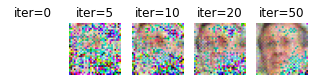

In [10]:
# generate dummy data and label
import time
 
from pytorch_msssim import ssim


#print (ssim(0.43*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),data_range=0).item())
#print (torch.dist(0.6*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),2).item())


for item in range(1):
    start = time.clock()
    for rd in range(1):

        torch.manual_seed(200*rd)

        # all random dummy init
        #dummy_data = torch.unsqueeze(torch.randn(gt_data[item].size()),0).to(device).requires_grad_(True)
        
        # all black dummy init
        #dummy_data = torch.unsqueeze(torch.zeros(gt_data[item].size()),0).to(device).requires_grad_(True)
        
        # all white dummy init
        dummy_data = torch.unsqueeze(torch.ones(gt_data[item].size()),0).to(device).requires_grad_(True)

        
        #background = torch.unsqueeze(torch.zeros(gt_data[item].size()),0)
        #background[0,0,::] = 1
        #dummy_data = background.to(device).requires_grad_(True)
        ##dummy_data = (torch.unsqueeze(torch.randn(gt_data[item].size()),0)+background).to(device).requires_grad_(True)
        
        #surrogate = torch.unsqueeze(gt_data[item+1],0)
        #aaa = torch.rand([3,16,16])
        #surrogate[0,:,8:24,8:24] =aaa
        #dummy_data = surrogate.to(device).requires_grad_(True)    
        
        #dummy_data = torch.unsqueeze(gt_data[item+1],0).to(device).requires_grad_(True)
        
        #k = np.random.randint(0,95)
        #dummy_data = torch.unsqueeze(gt_data[k],0).to(device).requires_grad_(True)
        
        ## original uncommented dummy_data initialisation in the repo - looks like patterened i.e. quadrants of a grid are the same
        # pat_1 = torch.rand([3,16,16])
        # pat_2 = torch.cat((pat_1,pat_1),dim=1)
        # pat_4 = torch.cat((pat_2,pat_2),dim=2)
        # dummy_data = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)
        
        ## original uncommented dummy_data initialisation in the repo - looks like patterened i.e. half-quadrants of a grid are the same
        #aaa = torch.rand([3,8,8])
        #bbb = torch.cat((aaa,aaa),dim=1)
        #ccc = torch.cat((bbb,bbb),dim=1)
        #ddd = torch.cat((ccc,ccc),dim=2)
        #eee = torch.cat((ddd,ddd),dim=2)
        #dummy_data = torch.unsqueeze(eee,dim=0).to(device).requires_grad_(True)
        
        #aaa = torch.rand([3,4,4])
        #bbb = torch.cat((aaa,aaa),dim=1)
        #ccc = torch.cat((bbb,bbb),dim=1)
        #ddd = torch.cat((ccc,ccc),dim=1)
        #eee = torch.cat((ddd,ddd),dim=2)
        #fff = torch.cat((eee,eee),dim=2)
        #ggg = torch.cat((fff,fff),dim=2)
        #dummy_data = torch.unsqueeze(ggg,dim=0).to(device).requires_grad_(True)
        
        
        #dummy_data = plt.imread("./attack_image/replacement_69.png")
        #print (dummy_data.shape)
        #dummy_data = torch.FloatTensor(dummy_data).to(device)
        #dummy_data = dummy_data.transpose(2,3).transpose(1,2)
        
        dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)
        
        dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
        label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                dim=-1).detach().reshape((1,)).requires_grad_(False)
        #print (original_dy_dx[item][-1].shape)
        #print (original_dy_dx[item][-1].argmin())
        
        #print (torch.sum(original_dy_dx[item][-2], dim=-1).argmin())
        
        plt.imshow(tt(dummy_data[0].cpu()))
        plt.title("Dummy data")
        #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

        plt.clf()
        print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        print("stolen label is %d." % label_pred.item())
        
        
        #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
        optimizer = torch.optim.LBFGS([dummy_data,])
        #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)
        #optimizer = torch.optim.SGD([dummy_data,],lr=0.01)
      
       

        history = []
        
        percept_dis = np.zeros(300)
        recover_dis = np.zeros(300)
        for iters in range(100):
            
          
            #percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[item],dim=0),data_range=0).item()
            #recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()
           
            history.append(tt(dummy_data[0].cpu()))
            def closure():
                optimizer.zero_grad()

                pred = net(dummy_data) 
                
                #dummy_onehot_label = F.softmax(dummy_label, dim=-1).long()
                
                #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
                ##print (pred)
                ##print (label_pred)
            
                dummy_loss = criterion(pred, label_pred)
                dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                ##dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                ##print (dummy_dy_dp[0].shape)  

                grad_diff = 0
                grad_count = 0
                #count =0
                for gx, gy in zip(dummy_dy_dx, original_dy_dx[item]): # TODO: fix the variablas here
                   
                    #if iters==500 or iters== 1200:
                    #print (gx[0])
                    #    print ('hahaha')
                    #print (gy[0])
                    lasso = torch.norm(dummy_data,p=1)
                    ridge = torch.norm(dummy_data,p=2)
                    grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                    
                    #print (gx.shape)

                    grad_count += gx.nelement()
                

                    #if count == 9:
                    #    break
                    #count=count+1
                # grad_diff = grad_diff / grad_count * 1000
                
                #grad_diff += ((original_pred[item]-pred)**2).sum()
               
                
                
                
                grad_diff.backward()
                #print (count)

                #print (dummy_dy_dx)
                #print (original_dy_dx)


                return grad_diff



            optimizer.step(closure)
            if iters % 5 == 0: 
                current_loss = closure()
                #if iters == 0: 
                print ("%.8f" % current_loss.item())
                #print(iters, "%.8f" % current_loss.item())
            history.append(tt(dummy_data[0].cpu()))

        
        
        #plt.figure(figsize=(18, 12))
        #for i in range(60):
        #  plt.subplot(6, 10, i + 1)
        #  plt.imshow(history[i * 5])
        #  plt.title("iter=%d" % (i * 5))
        #  plt.axis('off')
        
        plt.figure(figsize=(12, 1.5))
        #iter_idx = [0,20,40,60,80,100,120,140,160,180]
        plt.figure(figsize=(6.5, 1.2))
        #iter_idx = [0,1000,2000,3000,4000,5000]
        iter_idx = [0,5,10,20,50]
        

        for i in range(5):
          plt.subplot(1, 6, i + 1)
          plt.imshow(history[iter_idx[i]])
          plt.title("iter=%d" % (iter_idx[i]))
          plt.axis('off')
            
        #np.savetxt('ssim_random2',percept_dis,fmt="%4f")
        #np.savetxt('mse_random2',recover_dis,fmt="%4f")
        
        #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
        # plt.savefig("./attack_image/index_%s_rand_%s_label_%s"%(item,rd, label_pred.item()))
        #plt.clf()
       
    duration = time.clock()-start
    #print ("Running time is %.4f." %(duration/10.0) )
    print (duration/10.0 )
    
        

IndexError: ignored

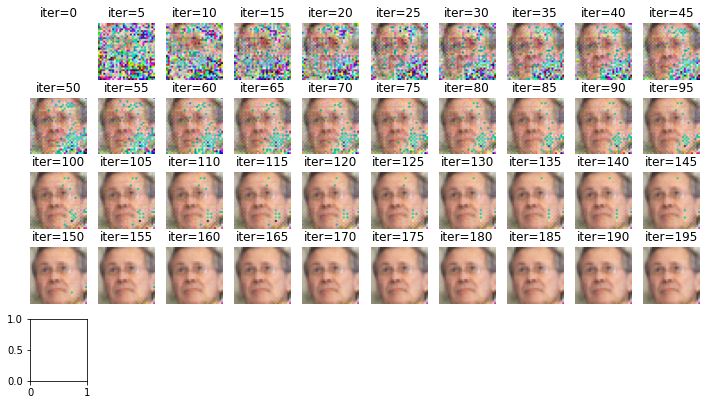

In [11]:
plt.figure(figsize=(12, 8))
for i in range(60):
  plt.subplot(6, 10, i + 1)
  plt.imshow(history[i * 5])
  plt.title("iter=%d" % (i * 5))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:
plt.figure(figsize=(12, 8))
for j in range(batch):
    for i in range(60):
      plt.subplot(6, 10, i + 1)
      plt.imshow(history_batch[i * 5+j])
      plt.title("iter=%d" % (i * 5+ j))
      plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [ ]:

from keras.datasets import mnist, cifar10, cifar100, fashion_mnist
from matplotlib import pyplot
# load dataset
datasetsToShow = [mnist, cifar10, cifar100, fashion_mnist]

for dataset in datasetsToShow:
  (trainX, trainy), (testX, testy) = dataset.load_data()
  # summarize loaded dataset
  print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
  print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
  # plot first few images
  for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off')
    # pyplot.title(f'Class : { trainy[i] }')
  # show the figure
  # pyplot.show()

# (X_train, trainy), (testX, testy) = dataset.load_data()
# summarize loaded dataset
# print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
# print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
  # define subplot
  pyplot.subplot(330 + 1 + i)
  # plot raw pixel data
  pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
  pyplot.axis('off')
  # pyplot.title(f'Class : { trainy[i] }')
# show the figure
pyplot.show()

1
2.396101474761963
fininshed training
0.1225071225071225
fininshed testing
idx is below
[28]
torch.Size([1, 3, 32, 32])
torch.Size([1, 1])
tensor([[4]])
torch.Size([1, 106])
batch ground truth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


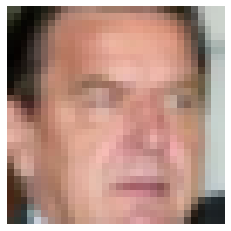

currbatchsize is 1
Dummy label is 4.
stolen label is 4.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:189: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0.04390409
0.00038149
0.00010756
0.00004865
0.00002683
0.00001724
0.00001186
0.00000836
0.00000625
0.00000473
0.00000360
0.00000285
0.00000227
0.00000187
0.00000157
0.00000131
0.00000115
0.00000103
0.00000095
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093
0.00000093


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

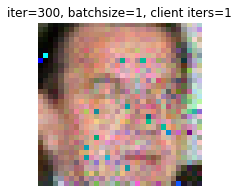

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:388: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


2.3382294000000003
########### Showing the results for the current B-C_Iters comnbo#######
[1, 1, 0.5953795313835144, tensor(0.0050, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6A8790>]
########### End of results for the current B-C_Iters comnbo#######
1
2.558579683303833
fininshed training
0.11965811965811966
fininshed testing
idx is below
[28, 33, 43, 56, 59]
torch.Size([5, 3, 32, 32])
torch.Size([5, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([5, 106])
batch ground truth


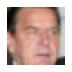

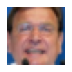

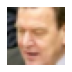

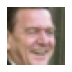

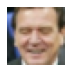

currbatchsize is 5
Dummy label is 4.
stolen label is 4.
1.17741072
1.03009939
1.02890205
1.02860844
1.02849817
1.02845085
1.02841818
1.02839744
1.02838731
1.02838004
1.02837443
1.02837265
1.02836812
1.02836156
1.02835894
1.02835751
1.02835643
1.02835464
1.02835357
1.02835226
1.02834904
1.02834833
1.02834761
1.02834702
1.02834618
1.02834523
1.02834475
1.02834392
1.02834272
1.02834117
1.02834070
1.02833986
1.02833903
1.02833879
1.02833819
1.02833784
1.02833724
1.02833652
1.02833629
1.02833545
1.02833462
1.02833402
1.02833366
1.02833283
1.02833211
1.02833176
1.02833080
1.02833045
1.02832985
1.02832949
1.02832878
1.02832782
1.02832723
1.02832639
1.02832603
1.02832520
1.02832496
1.02832472
1.02832437
1.02832377


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

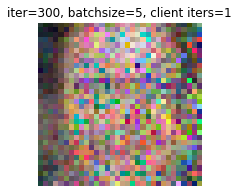

3.287414199999998
########### Showing the results for the current B-C_Iters comnbo#######
[5, 1, 0.12178760766983032, tensor(0.0486, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F385590>]
########### End of results for the current B-C_Iters comnbo#######
1
2.9152746200561523
fininshed training
0.11965811965811966
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96]
torch.Size([10, 3, 32, 32])
torch.Size([10, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([10, 106])
batch ground truth


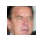

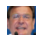

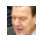

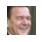

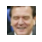

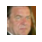

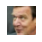

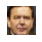

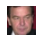

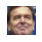

currbatchsize is 10
Dummy label is 4.
stolen label is 4.
1.62039971
1.45038283
1.44865167
1.44828880
1.44811499
1.44803941
1.44799566
1.44797730
1.44795787
1.44794214
1.44793403
1.44793105
1.44792569
1.44792187
1.44791138
1.44790745
1.44790232
1.44790018
1.44789326
1.44789135
1.44788742
1.44788420
1.44788170
1.44788027
1.44787800
1.44787562
1.44787467
1.44787335
1.44787300
1.44787097
1.44787025
1.44786775
1.44786632
1.44786417
1.44786322
1.44786227
1.44786155
1.44786072
1.44785988
1.44785941
1.44785798
1.44785631
1.44785535
1.44785523
1.44785416
1.44785357
1.44785190
1.44785070
1.44784975
1.44784832
1.44784808
1.44784653
1.44784534
1.44784474
1.44784415
1.44784367
1.44784296
1.44784236
1.44784200
1.44784153


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

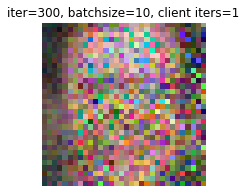

6.424075300000001
########### Showing the results for the current B-C_Iters comnbo#######
[10, 1, 0.08126448839902878, tensor(0.0666, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F4B2810>]
########### End of results for the current B-C_Iters comnbo#######
1
2.648254632949829
fininshed training
0.11965811965811966
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96, 131, 134, 142, 146, 147, 158, 171, 178, 180, 194]
torch.Size([20, 3, 32, 32])
torch.Size([20, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([20, 106])
batch ground truth


currbatchsize is 20
Dummy label is 4.
stolen label is 4.
2.30722189
2.09737897
2.09495711
2.09435534
2.09410930
2.09401679
2.09394622
2.09391356
2.09388947
2.09387732
2.09386420
2.09385848
2.09384966
2.09383535
2.09381866
2.09380937
2.09380126
2.09379530
2.09379053
2.09378433
2.09377766
2.09377432
2.09377050
2.09376550
2.09376097
2.09375906
2.09375548
2.09375191
2.09375048
2.09374857
2.09374261
2.09374046
2.09373784
2.09373498
2.09373307
2.09373069
2.09372926
2.09372663
2.09372258
2.09372091
2.09371734
2.09371376
2.09371233
2.09370971
2.09370852
2.09370613
2.09370208
2.09369922
2.09369874
2.09369445
2.09369349
2.09369230
2.09369135
2.09368992
2.09368825
2.09368682
2.09368587
2.09368372
2.09368324
2.09368134


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

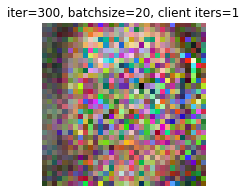

10.645850300000001
########### Showing the results for the current B-C_Iters comnbo#######
[20, 1, 0.038411255925893784, tensor(0.0855, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F865910>]
########### End of results for the current B-C_Iters comnbo#######
1
2.1011106967926025
2
2.4657654762268066
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28]
torch.Size([1, 3, 32, 32])
torch.Size([1, 1])
tensor([[4]])
torch.Size([1, 106])
batch ground truth


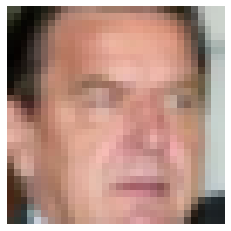

currbatchsize is 1
Dummy label is 41.
stolen label is 4.
0.00910484
0.00010774
0.00002562
0.00001147
0.00000663
0.00000424
0.00000290
0.00000213
0.00000167
0.00000132
0.00000111
0.00000091
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089
0.00000089


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

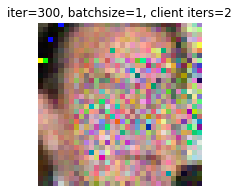

1.6608922000000006
########### Showing the results for the current B-C_Iters comnbo#######
[1, 2, 0.31503698229789734, tensor(0.0144, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F68D2D0>]
########### End of results for the current B-C_Iters comnbo#######
1
2.533813953399658
2
2.43261456489563
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59]
torch.Size([5, 3, 32, 32])
torch.Size([5, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([5, 106])
batch ground truth


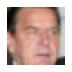

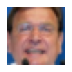

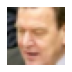

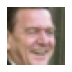

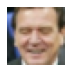

currbatchsize is 5
Dummy label is 41.
stolen label is 4.
0.28662956
0.26092020
0.26060799
0.26053292
0.26051018
0.26049474
0.26048458
0.26047879
0.26047513
0.26047137
0.26046875
0.26046616
0.26046547
0.26046425
0.26046380
0.26046157
0.26046076
0.26045966
0.26045901
0.26045847
0.26045781
0.26045713
0.26045647
0.26045567
0.26045525
0.26045504
0.26045468
0.26045400
0.26045349
0.26045302
0.26045275
0.26045245
0.26045191
0.26045132
0.26045099
0.26045072
0.26045048
0.26045018
0.26044995
0.26044950
0.26044929
0.26044899
0.26044881
0.26044855
0.26044846
0.26044834
0.26044810
0.26044804
0.26044789
0.26044774
0.26044768
0.26044753
0.26044738
0.26044726
0.26044697
0.26044685
0.26044670
0.26044652
0.26044643
0.26044628


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

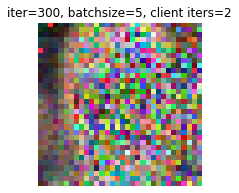

3.7879047999999953
########### Showing the results for the current B-C_Iters comnbo#######
[5, 2, 0.054748792201280594, tensor(0.0964, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6A8390>]
########### End of results for the current B-C_Iters comnbo#######
1
2.281569004058838
2
2.4301438331604004
fininshed training
0.15954415954415954
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96]
torch.Size([10, 3, 32, 32])
torch.Size([10, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([10, 106])
batch ground truth


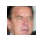

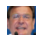

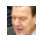

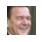

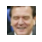

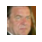

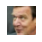

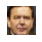

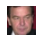

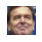

currbatchsize is 10
Dummy label is 41.
stolen label is 4.
0.32643196
0.28728652
0.28688875
0.28677046
0.28672916
0.28670347
0.28669277
0.28668246
0.28667670
0.28666961
0.28666645
0.28666145
0.28665927
0.28665644
0.28665292
0.28665188
0.28665078
0.28664997
0.28664899
0.28664851
0.28664777
0.28664631
0.28664562
0.28664488
0.28664389
0.28664309
0.28664273
0.28664210
0.28664073
0.28664026
0.28663972
0.28663892
0.28663826
0.28663814
0.28663746
0.28663668
0.28663632
0.28663597
0.28663576
0.28663510
0.28663465
0.28663421
0.28663391
0.28663343
0.28663275
0.28663227
0.28663218
0.28663170
0.28663111
0.28663048
0.28663009
0.28662965
0.28662959
0.28662893
0.28662863
0.28662848
0.28662816
0.28662786
0.28662771
0.28662708


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

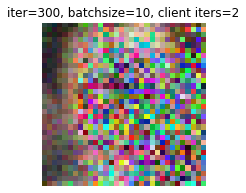

6.457935800000001
########### Showing the results for the current B-C_Iters comnbo#######
[10, 2, 0.04013325273990631, tensor(0.1178, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F5C0F50>]
########### End of results for the current B-C_Iters comnbo#######
1
2.190932273864746
2
2.1962246894836426
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96, 131, 134, 142, 146, 147, 158, 171, 178, 180, 194]
torch.Size([20, 3, 32, 32])
torch.Size([20, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([20, 106])
batch ground truth


currbatchsize is 20
Dummy label is 41.
stolen label is 4.
0.45424137
0.41744474
0.41687140
0.41668549
0.41658452
0.41651937
0.41649082
0.41645998
0.41643906
0.41642809
0.41642225
0.41641331
0.41640934
0.41640192
0.41639781
0.41639394
0.41639245
0.41638955
0.41638702
0.41638455
0.41638172
0.41637972
0.41637713
0.41637397
0.41637284
0.41636869
0.41636667
0.41636467
0.41636226
0.41635928
0.41635722
0.41635534
0.41635481
0.41635305
0.41635025
0.41634905
0.41634691
0.41634625
0.41634509
0.41634306
0.41634133
0.41634050
0.41633961
0.41633835
0.41633764
0.41633666
0.41633597
0.41633517
0.41633493
0.41633433
0.41633356
0.41633287
0.41633162
0.41633105
0.41633037
0.41633007
0.41632921
0.41632849
0.41632801
0.41632718


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

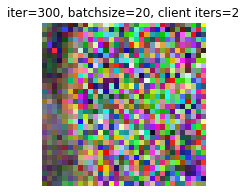

13.642170599999996
########### Showing the results for the current B-C_Iters comnbo#######
[20, 2, 0.02637770213186741, tensor(0.3639, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6A8550>]
########### End of results for the current B-C_Iters comnbo#######
1
1.947707176208496
2
2.0682265758514404
3
2.137300968170166
4
1.7903881072998047
5
1.7364813089370728
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28]
torch.Size([1, 3, 32, 32])
torch.Size([1, 1])
tensor([[4]])
torch.Size([1, 106])
batch ground truth


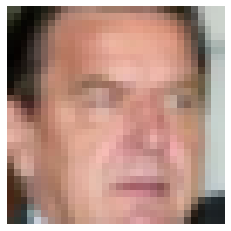

currbatchsize is 1
Dummy label is 55.
stolen label is 4.
0.00134173
0.00001365
0.00000508
0.00000217
0.00000133
0.00000080
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062
0.00000062


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

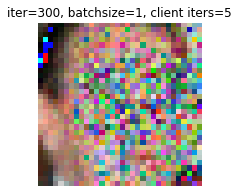

1.0456766000000015
########### Showing the results for the current B-C_Iters comnbo#######
[1, 5, 0.15354673564434052, tensor(0.0357, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF601DDB10>]
########### End of results for the current B-C_Iters comnbo#######
1
1.9529757499694824
2
2.063830852508545
3
1.9873493909835815
4
1.8236126899719238
5
1.8538846969604492
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59]
torch.Size([5, 3, 32, 32])
torch.Size([5, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([5, 106])
batch ground truth


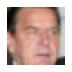

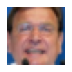

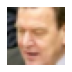

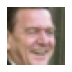

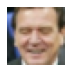

currbatchsize is 5
Dummy label is 55.
stolen label is 4.
0.03082526
0.02578324
0.02572550
0.02570932
0.02570206
0.02569802
0.02569558
0.02569395
0.02569289
0.02569213
0.02569140
0.02569079
0.02569031
0.02568997
0.02568979
0.02568952
0.02568928
0.02568918
0.02568902
0.02568875
0.02568858
0.02568842
0.02568831
0.02568826
0.02568822
0.02568816
0.02568799
0.02568791
0.02568783
0.02568777
0.02568771
0.02568766
0.02568763
0.02568755
0.02568750
0.02568746
0.02568739
0.02568733
0.02568731
0.02568723
0.02568720
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712
0.02568712


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

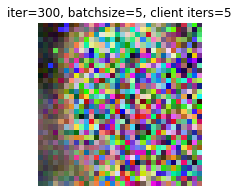

4.4157782
########### Showing the results for the current B-C_Iters comnbo#######
[5, 5, 0.04210744798183441, tensor(0.1610, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6E4210>]
########### End of results for the current B-C_Iters comnbo#######
1
1.8691370487213135
2
1.9226980209350586
3
1.8530855178833008
4
1.7535954713821411
5
1.8521950244903564
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96]
torch.Size([10, 3, 32, 32])
torch.Size([10, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([10, 106])
batch ground truth


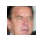

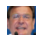

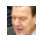

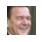

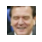

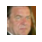

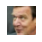

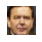

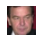

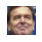

currbatchsize is 10
Dummy label is 55.
stolen label is 4.
0.06409632
0.05281379
0.05269760
0.05266720
0.05265371
0.05264558
0.05263979
0.05263541
0.05263269
0.05263083
0.05262997
0.05262883
0.05262793
0.05262687
0.05262619
0.05262572
0.05262514
0.05262457
0.05262389
0.05262318
0.05262275
0.05262252
0.05262211
0.05262164
0.05262147
0.05262130
0.05262117
0.05262098
0.05262068
0.05262046
0.05262013
0.05261995
0.05261969
0.05261955
0.05261937
0.05261929
0.05261913
0.05261899
0.05261872
0.05261854
0.05261838
0.05261814
0.05261800
0.05261794
0.05261779
0.05261757
0.05261736
0.05261724
0.05261713
0.05261703
0.05261694
0.05261687
0.05261672
0.05261660
0.05261650
0.05261635
0.05261626
0.05261619
0.05261615
0.05261604


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

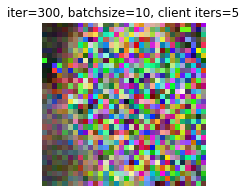

8.344161600000007
########### Showing the results for the current B-C_Iters comnbo#######
[10, 5, 0.029658323153853416, tensor(0.2115, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F68FCD0>]
########### End of results for the current B-C_Iters comnbo#######
1
1.8198816776275635
2
1.9442609548568726
3
1.9122896194458008
4
1.737606167793274
5
1.8650414943695068
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96, 131, 134, 142, 146, 147, 158, 171, 178, 180, 194]
torch.Size([20, 3, 32, 32])
torch.Size([20, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([20, 106])
batch ground truth


currbatchsize is 20
Dummy label is 55.
stolen label is 4.
0.13431378
0.11929452
0.11909825
0.11904175
0.11901489
0.11900095
0.11898869
0.11897965
0.11897263
0.11896694
0.11896329
0.11896003
0.11895744
0.11895479
0.11895343
0.11895233
0.11895133
0.11894979
0.11894939
0.11894811
0.11894684
0.11894543
0.11894458
0.11894354
0.11894269
0.11894178
0.11894096
0.11894019
0.11893924
0.11893822
0.11893755
0.11893694
0.11893650
0.11893598
0.11893550
0.11893494
0.11893471
0.11893433
0.11893391
0.11893345
0.11893323
0.11893281
0.11893263
0.11893235
0.11893205
0.11893184
0.11893149
0.11893132
0.11893100
0.11893070
0.11893040
0.11893022
0.11892992
0.11892963
0.11892936
0.11892922
0.11892904
0.11892886
0.11892861
0.11892857


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

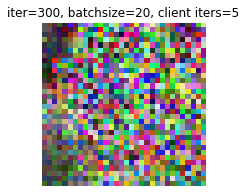

15.477215300000001
########### Showing the results for the current B-C_Iters comnbo#######
[20, 5, 0.018765034154057503, tensor(0.3751, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F682890>]
########### End of results for the current B-C_Iters comnbo#######
1
1.814857840538025
2
1.8812435865402222
3
1.8601315021514893
4
1.7488884925842285
5
1.8195042610168457
6
1.9537009000778198
7
1.7876421213150024
8
1.811505913734436
9
1.9783169031143188
10
1.9532427787780762
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28]
torch.Size([1, 3, 32, 32])
torch.Size([1, 1])
tensor([[4]])
torch.Size([1, 106])
batch ground truth


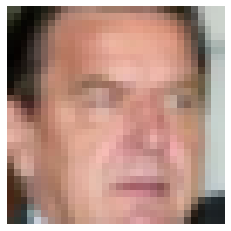

currbatchsize is 1
Dummy label is 73.
stolen label is 4.
0.00076863
0.00000733
0.00000201
0.00000100
0.00000066
0.00000050
0.00000047
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

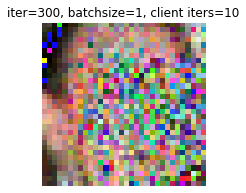

1.005699299999992
########### Showing the results for the current B-C_Iters comnbo#######
[1, 10, 0.12270808219909668, tensor(0.0458, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6919D0>]
########### End of results for the current B-C_Iters comnbo#######
1
1.9610031843185425
2
2.0862977504730225
3
1.9762625694274902
4
1.8475152254104614
5
1.740195631980896
6
1.7384675741195679
7
1.942641019821167
8
2.0008387565612793
9
1.6097811460494995
10
1.9428104162216187
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59]
torch.Size([5, 3, 32, 32])
torch.Size([5, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([5, 106])
batch ground truth


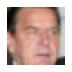

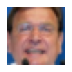

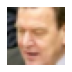

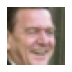

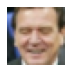

currbatchsize is 5
Dummy label is 73.
stolen label is 4.
0.01653989
0.01380262
0.01377137
0.01376373
0.01376058
0.01375953
0.01375862
0.01375797
0.01375749
0.01375720
0.01375686
0.01375675
0.01375661
0.01375650
0.01375646
0.01375639
0.01375633
0.01375628
0.01375623
0.01375613
0.01375609
0.01375605
0.01375600
0.01375597
0.01375594
0.01375592
0.01375591
0.01375589
0.01375587
0.01375585
0.01375583
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582
0.01375582


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

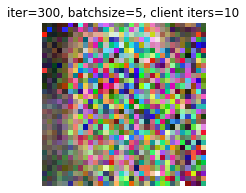

2.8241063000000053
########### Showing the results for the current B-C_Iters comnbo#######
[5, 10, 0.04108181595802307, tensor(0.0897, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F296E50>]
########### End of results for the current B-C_Iters comnbo#######
1
2.0628488063812256
2
2.188697576522827
3
1.8955916166305542
4
1.8561919927597046
5
1.8719995021820068
6
1.8014416694641113
7
1.916516900062561
8
1.9806652069091797
9
1.6279419660568237
10
2.0023386478424072
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96]
torch.Size([10, 3, 32, 32])
torch.Size([10, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([10, 106])
batch ground truth


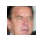

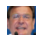

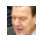

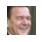

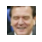

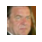

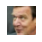

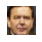

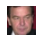

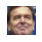

currbatchsize is 10
Dummy label is 73.
stolen label is 4.
0.02338813
0.01988262
0.01983727
0.01982547
0.01982021
0.01981777
0.01981635
0.01981537
0.01981482
0.01981432
0.01981402
0.01981381
0.01981371
0.01981353
0.01981345
0.01981335
0.01981327
0.01981317
0.01981303
0.01981291
0.01981284
0.01981281
0.01981274
0.01981265
0.01981260
0.01981250
0.01981246
0.01981243
0.01981239
0.01981233
0.01981227
0.01981223
0.01981219
0.01981212
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209
0.01981209


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

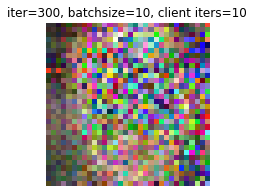

5.3249162999999955
########### Showing the results for the current B-C_Iters comnbo#######
[10, 10, 0.02333010546863079, tensor(0.0886, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F691150>]
########### End of results for the current B-C_Iters comnbo#######
1
2.053699493408203
2
2.1515884399414062
3
1.959347128868103
4
1.807929277420044
5
1.7798794507980347
6
1.9009239673614502
7
1.8996578454971313
8
1.8857488632202148
9
1.6232554912567139
10
1.9073046445846558
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96, 131, 134, 142, 146, 147, 158, 171, 178, 180, 194]
torch.Size([20, 3, 32, 32])
torch.Size([20, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([20, 106])
batch 

currbatchsize is 20
Dummy label is 73.
stolen label is 4.
0.03654819
0.03171502
0.03165023
0.03163168
0.03162424
0.03161962
0.03161761
0.03161583
0.03161418
0.03161318
0.03161261
0.03161235
0.03161187
0.03161141
0.03161130
0.03161118
0.03161100
0.03161079
0.03161052
0.03161037
0.03161028
0.03161015
0.03160992
0.03160985
0.03160969
0.03160958
0.03160946
0.03160939
0.03160930
0.03160923
0.03160916
0.03160914
0.03160904
0.03160896
0.03160888
0.03160884
0.03160878
0.03160873
0.03160870
0.03160863
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860
0.03160860


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

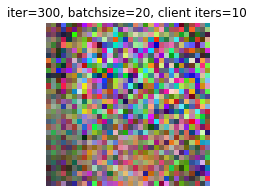

9.190006799999992
########### Showing the results for the current B-C_Iters comnbo#######
[20, 10, 0.01923837698996067, tensor(0.0973, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F677C10>]
########### End of results for the current B-C_Iters comnbo#######
1
2.0222084522247314
2
2.2000083923339844
3
1.9966732263565063
4
1.7728979587554932
5
1.644361972808838
6
1.7388814687728882
7
1.902687907218933
8
1.8847973346710205
9
1.6007343530654907
10
1.887696623802185
11
1.923335075378418
12
1.9282803535461426
13
1.8163939714431763
14
1.991060495376587
15
1.902463674545288
16
2.260422468185425
17
1.8938345909118652
18
1.869615077972412
19
1.8528367280960083
20
1.9390908479690552
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28]
torch.Size([1, 3, 32, 32])
torch.Size([1, 1])
tensor([[4]])
torch.Size([1, 106])
batch ground truth


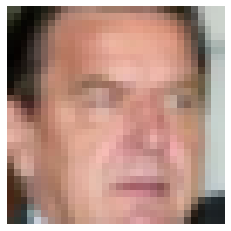

currbatchsize is 1
Dummy label is 4.
stolen label is 4.
0.00055718
0.00001020
0.00000302
0.00000137
0.00000079
0.00000052
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043
0.00000043


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

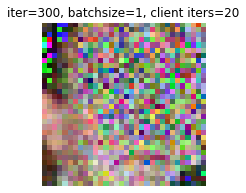

1.1330025000000206
########### Showing the results for the current B-C_Iters comnbo#######
[1, 20, 0.12058582901954651, tensor(0.0452, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F920D90>]
########### End of results for the current B-C_Iters comnbo#######
1
1.9278442859649658
2
2.0646729469299316
3
1.8794993162155151
4
2.0379409790039062
5
1.950075387954712
6
1.9286303520202637
7
1.7934041023254395
8
2.014564275741577
9
1.6778205633163452
10
1.793069839477539
11
1.841835379600525
12
1.9937580823898315
13
1.7363765239715576
14
1.8701934814453125
15
1.712988257408142
16
2.0069332122802734
17
1.6918073892593384
18
2.114612579345703
19
1.9291377067565918
20
2.054572105407715
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59]
torch.Size([5, 3, 32, 32])
torch.Size([5, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4]])
torch.Size([5, 106])
batch ground truth


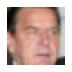

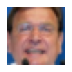

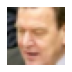

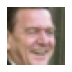

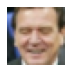

currbatchsize is 5
Dummy label is 4.
stolen label is 4.
0.00975609
0.00834340
0.00832585
0.00832156
0.00831995
0.00831907
0.00831847
0.00831807
0.00831782
0.00831766
0.00831750
0.00831747
0.00831743
0.00831739
0.00831734
0.00831730
0.00831727
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726
0.00831726


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

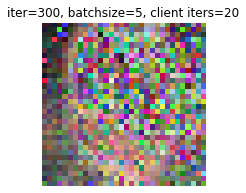

2.3251138999999967
########### Showing the results for the current B-C_Iters comnbo#######
[5, 20, 0.050351131707429886, tensor(0.0663, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6A4FD0>]
########### End of results for the current B-C_Iters comnbo#######
1
1.942642331123352
2
1.9888278245925903
3
1.9111552238464355
4
2.048585891723633
5
2.0280404090881348
6
2.037885904312134
7
1.9326732158660889
8
2.0016543865203857
9
1.6710922718048096
10
1.8845065832138062
11
1.8585091829299927
12
2.00653076171875
13
1.7223014831542969
14
1.8395103216171265
15
1.6947919130325317
16
1.952873945236206
17
1.7433052062988281
18
2.1633574962615967
19
1.945023536682129
20
2.118176221847534
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96]
torch.Size([10, 3, 32, 32])
torch.Size([10, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
        [4],
       

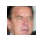

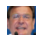

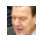

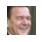

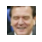

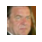

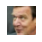

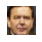

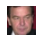

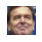

currbatchsize is 10
Dummy label is 4.
stolen label is 4.
0.04969602
0.04058849
0.04049216
0.04046677
0.04045576
0.04044978
0.04044742
0.04044477
0.04044291
0.04044200
0.04044144
0.04044072
0.04044056
0.04044014
0.04043970
0.04043930
0.04043916
0.04043901
0.04043881
0.04043866
0.04043841
0.04043829
0.04043822
0.04043796
0.04043779
0.04043772
0.04043759
0.04043749
0.04043735
0.04043727
0.04043721
0.04043711
0.04043705
0.04043698
0.04043693
0.04043687
0.04043685
0.04043680
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679
0.04043679


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

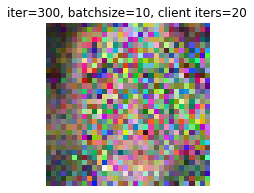

5.798601099999996
########### Showing the results for the current B-C_Iters comnbo#######
[10, 20, 0.04672371968626976, tensor(0.0709, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6FFD10>]
########### End of results for the current B-C_Iters comnbo#######
1
1.9880220890045166
2
1.9519734382629395
3
1.9670230150222778
4
2.0070693492889404
5
1.9567735195159912
6
1.9484037160873413
7
1.8294217586517334
8
2.012833833694458
9
1.601070523262024
10
1.95847487449646
11
1.929792881011963
12
2.011068344116211
13
1.7043721675872803
14
1.855255365371704
15
1.6829884052276611
16
1.9019780158996582
17
1.7351891994476318
18
2.0873217582702637
19
1.9378225803375244
20
2.0739901065826416
fininshed training
0.38746438746438744
fininshed testing
idx is below
[28, 33, 43, 56, 59, 65, 83, 89, 91, 96, 131, 134, 142, 146, 147, 158, 171, 178, 180, 194]
torch.Size([20, 3, 32, 32])
torch.Size([20, 1])
tensor([[4],
        [4],
        [4],
        [4],
        [4],
        [

currbatchsize is 20
Dummy label is 4.
stolen label is 4.
0.07621097
0.06561094
0.06546965
0.06544112
0.06542592
0.06541727
0.06541214
0.06540979
0.06540807
0.06540653
0.06540576
0.06540532
0.06540464
0.06540415
0.06540372
0.06540328
0.06540301
0.06540265
0.06540222
0.06540193
0.06540161
0.06540120
0.06540102
0.06540075
0.06540047
0.06540020
0.06540004
0.06539997
0.06539980
0.06539959
0.06539945
0.06539927
0.06539918
0.06539904
0.06539893
0.06539883
0.06539875
0.06539872
0.06539861
0.06539856
0.06539854
0.06539845
0.06539835
0.06539828
0.06539823
0.06539809
0.06539807
0.06539799
0.06539777
0.06539770
0.06539761
0.06539754
0.06539744
0.06539733
0.06539726
0.06539721
0.06539715
0.06539708
0.06539703
0.06539703


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

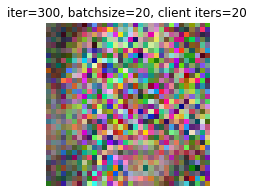

11.224687100000006
########### Showing the results for the current B-C_Iters comnbo#######
[20, 20, 0.028875375166535378, tensor(0.1004, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F920350>]
########### End of results for the current B-C_Iters comnbo#######
1
1.9940842390060425
2
1.9620224237442017
3
1.9834282398223877
4
1.9934799671173096
5
1.956464409828186
6
1.9225211143493652
7
1.7884070873260498
8
1.9546244144439697
9
1.6124597787857056
10
1.8975324630737305
11
1.8892464637756348
12
2.014986276626587
13
1.7181278467178345
14
1.8335647583007812
15
1.697045087814331
16
1.922748327255249
17
1.7429065704345703
18
2.09451961517334
19
1.9262957572937012
20
2.0706183910369873
21
1.670696496963501
22
2.0525176525115967
23
1.8964128494262695
24
2.0435495376586914
25
2.002056837081909
26
2.1127114295959473
27
2.077564001083374
28
2.0053727626800537
29
2.0508244037628174
30
1.8138881921768188
31
1.9779751300811768
32
2.0097146034240723
33
1.79430103302001

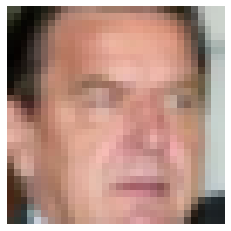

currbatchsize is 1
Dummy label is 43.
stolen label is 4.
0.00309789
0.00004028
0.00001058
0.00000462
0.00000245
0.00000177
0.00000127
0.00000104
0.00000090
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088
0.00000088


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

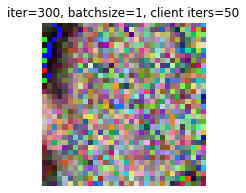

1.3186439999999948
########### Showing the results for the current B-C_Iters comnbo#######
[1, 50, 0.10388239473104477, tensor(0.0495, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F920550>]
########### End of results for the current B-C_Iters comnbo#######
1
2.146347761154175
2
2.152376651763916
3
2.0960323810577393
4
2.1229350566864014
5
1.903043508529663
6
1.8839467763900757
7
1.81009042263031
8
1.728096842765808
9
1.7886031866073608
10
1.7524453401565552
11
2.0602190494537354
12
1.913887619972229
13
1.8354977369308472
14
1.5700033903121948
15
1.8462635278701782
16
1.4408193826675415
17
1.954359531402588
18
1.705905556678772
19
1.8515733480453491
20
2.010364532470703
21
1.8363819122314453
22
1.9131646156311035
23
2.0305862426757812
24
2.020895481109619
25
1.8262262344360352
26
2.0490665435791016
27
1.8393783569335938
28
1.893977165222168
29
2.088278293609619
30
1.7378168106079102
31
2.0682895183563232
32
2.063511610031128
33
1.8258644342422485
fini

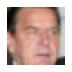

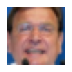

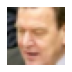

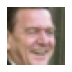

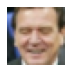

currbatchsize is 5
Dummy label is 43.
stolen label is 4.
0.37362933
0.33250675
0.33204424
0.33193219
0.33188641
0.33185822
0.33184424
0.33183423
0.33182326
0.33181924
0.33181438
0.33180901
0.33180538
0.33180296
0.33180010
0.33179814
0.33179563
0.33179295
0.33179092
0.33178979
0.33178788
0.33178675
0.33178577
0.33178425
0.33178329
0.33178228
0.33178115
0.33178052
0.33178008
0.33177951
0.33177897
0.33177847
0.33177817
0.33177742
0.33177641
0.33177572
0.33177513
0.33177456
0.33177394
0.33177364
0.33177292
0.33177254
0.33177221
0.33177197
0.33177173
0.33177128
0.33177081
0.33177039
0.33177024
0.33176959
0.33176902
0.33176875
0.33176851
0.33176818
0.33176750
0.33176705
0.33176690
0.33176661
0.33176643
0.33176610


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

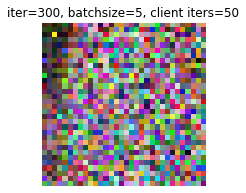

4.4455602
########### Showing the results for the current B-C_Iters comnbo#######
[5, 50, 0.022560222074389458, tensor(0.1288, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F8B0350>]
########### End of results for the current B-C_Iters comnbo#######
1
2.1124439239501953
2
2.0544917583465576
3
1.996788740158081
4
2.0140042304992676
5
1.9340028762817383
6
1.9834054708480835
7
1.89743971824646
8
1.6750874519348145
9
1.8031145334243774
10
1.7415649890899658
11
2.0888752937316895
12
2.0127294063568115
13
1.874651312828064
14
1.5438892841339111
15
1.8599761724472046
16
1.4406064748764038
17
1.9202479124069214
18
1.71405029296875
19
1.8721942901611328
20
1.9621429443359375
21
1.7983144521713257
22
1.8762363195419312
23
2.009887218475342
24
1.9891847372055054
25
1.7985541820526123
26
2.0204880237579346
27
1.8256900310516357
28
1.8756842613220215
29
2.0599005222320557
30
1.7356411218643188
31
2.0490381717681885
32
2.036639928817749
33
1.8250198364257812
finins

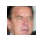

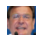

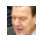

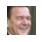

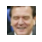

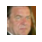

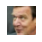

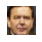

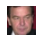

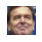

currbatchsize is 10
Dummy label is 43.
stolen label is 4.
1.75115001
1.54902816
1.54639304
1.54563224
1.54525506
1.54505742
1.54492664
1.54483259
1.54479051
1.54475033
1.54471886
1.54470003
1.54467106
1.54464984
1.54463005
1.54461360
1.54459274
1.54458368
1.54456639
1.54454875
1.54453754
1.54452777
1.54451561
1.54451156
1.54450226
1.54449224
1.54448700
1.54447746
1.54447246
1.54446030
1.54445076
1.54444361
1.54443991
1.54443705
1.54443264
1.54442573
1.54442215
1.54441869
1.54441428
1.54441071
1.54440641
1.54440355
1.54439986
1.54439723
1.54439533
1.54439318
1.54439151
1.54438949
1.54438829
1.54438663
1.54438436
1.54438257
1.54437923
1.54437721
1.54437387
1.54437268
1.54437029
1.54436910
1.54436731
1.54436564


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

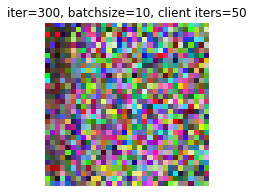

8.003100199999995
########### Showing the results for the current B-C_Iters comnbo#######
[10, 50, 0.013512883335351944, tensor(0.1724, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6FF590>]
########### End of results for the current B-C_Iters comnbo#######
1
2.068079948425293
2
2.0352988243103027
3
1.9873961210250854
4
1.9716123342514038
5
1.8937482833862305
6
1.9092422723770142
7
1.8423426151275635
8
1.6180835962295532
9
1.7776520252227783
10
1.7301809787750244
11
2.0158212184906006
12
1.9588592052459717
13
1.79275381565094
14
1.5270493030548096
15
1.8209950923919678
16
1.395449161529541
17
1.855804204940796
18
1.6821379661560059
19
1.8375084400177002
20
1.9470057487487793
21
1.782423973083496
22
1.8721035718917847
23
1.963400959968567
24
1.9407496452331543
25
1.7790895700454712
26
1.9591186046600342
27
1.776043176651001
28
1.8183521032333374
29
2.031635284423828
30
1.6984983682632446
31
1.9993971586227417
32
2.0087432861328125
33
1.767846465110778

currbatchsize is 20
Dummy label is 43.
stolen label is 4.
19.83854866
11.00352669
10.90239811
10.88089180
10.87380314
10.87069035
10.86898613
10.86775875
10.86669636
10.86594868
10.86533928
10.86482906
10.86437702
10.86397934
10.86376190
10.86353779
10.86334896
10.86314678
10.86303520
10.86295414
10.86279297
10.86264038
10.86256313
10.86248398
10.86240292
10.86225891
10.86217117
10.86210060
10.86199570
10.86191082
10.86187267
10.86177826
10.86168003
10.86161709
10.86153698
10.86148071
10.86143970
10.86139488
10.86134243
10.86126232
10.86117554
10.86114597
10.86108589
10.86104107
10.86099815
10.86095047
10.86091709
10.86089325
10.86085892
10.86082268
10.86079693
10.86077595
10.86076927
10.86071205
10.86065674
10.86062527
10.86059666
10.86055279
10.86050892
10.86049652


<Figure size 432x288 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

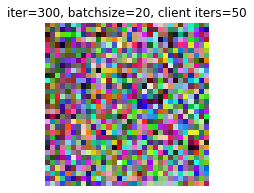

15.085103099999992
########### Showing the results for the current B-C_Iters comnbo#######
[20, 50, 0.008418558165431023, tensor(0.2812, grad_fn=<MseLossBackward>), <PIL.Image.Image image mode=RGB size=32x32 at 0x7FBF5F6A4C90>]
########### End of results for the current B-C_Iters comnbo#######


In [7]:
## Mega loop to generate all batchsize and client iteration combos
import itertools
import torch.nn.functional as F

grandssimNmses = []
iter_ = 0
batch_size = [1,5,10,20,32]
maxiters = [1,2,5,10,20,50]

combos = [[1,2,5,10,20,50],[1,5,10,20]]
combos = list(itertools.product(*combos)) 
batchmem = -1
for curriterlim, currbatchsize in combos:
  results = [currbatchsize, curriterlim]
  iter_ = 0
  for epoch in range(1):
      for i,data in enumerate(trainloader,0):
          #if epoch>=1:
            if iter_>=curriterlim and batchmem == currbatchsize:
              break
            batchmem = currbatchsize
            iter_=iter_+1
            print (iter_)
            inputs,label = data
            inputs,label =  Variable(inputs),Variable(label) 
            optimizer_train.zero_grad()
            outputs_benign=net(inputs)
            #outputs_benign = F.softmax(outputs_benign, dim=-1)
            #print (outputs_benign[0])
            loss_benign =  criterion_train(outputs_benign,label)
            #print("loss computed")
            loss_benign.backward()
            #print("loss BP")
            optimizer_train.step()
            #if i%2000==0:
            print (loss_benign.item())
            #torch.save(net.state_dict(),'./LFW_net.pth')  
        
    
  print ('fininshed training')
  total = len(y_test)
  acc =0.0
  for ct in range(total):
      testing_data = tt(testing[ct][0].cpu())
      testing_data1 = tp(testing_data).to(device)
      testing_data2 = testing_data1.view(1, *testing_data1.size())
      y_pred = net(testing_data2)
      predicted = torch.argmax(y_pred)
    
      if predicted == y_test[ct]:
          acc=acc+1
  accuracy = acc / total
  print (accuracy)
  print ('fininshed testing')



  ######### honest partipant #########
  img_index = 7   #use img_index
  dst_pil = tt(dst_tensor[img_index][0].cpu())   #use img_index

  gt_data = tp(dst_pil).to(device)
  gt_data = torch.unsqueeze(gt_data,0)

  gt_label = dst_tensor[img_index][1].long().to(device) #use img_index
  gt_label = gt_label.view(1, )
  gt_onehot_label = label_to_onehot(gt_label, num_classes=106)

  plt.imshow(dst_pil)
  #plt.savefig("./original/index_%s_label_%s"%(img_index,gt_label.item()))


  batch = currbatchsize
  idx_m = []
  match = 1
  for s in range(1000):
      if dst_tensor[s][1]==gt_label:
          if match<2:
              match = match + 1
          else:    
            idx_m.append(s)
          
          dst_pil = tt(dst_tensor[s][0].cpu())
          plt.imshow(dst_pil)
          plt.axis('off')
          #plt.savefig("./original/lfw_batch_idx_%s"%(len(idx_m)))
          
          
          if len(idx_m)==batch:
              break
  print("idx is below")
  print (idx_m)

  #
  for bat in range(batch-1):
      # dst_pil = tt(dst_tensor[img_index+1+bat][0].cpu())   #use img_index
      dst_pil = tt(dst_tensor[idx_m[bat+1]][0].cpu())
      tmp = torch.unsqueeze(tp(dst_pil).to(device),0)
      #print(tmp.shape)
      gt_data = torch.cat((gt_data,tmp),0)
      
      gt_label_tmp = dst_tensor[idx_m[bat+1]][1].long().to(device) #use img_index
      gt_label_tmp = gt_label_tmp.view(1, )
      gt_label = torch.cat((gt_label,gt_label_tmp),0)
      gt_onehot_label = torch.cat((gt_onehot_label,label_to_onehot(gt_label_tmp, num_classes=106)),0)
      
      # if gt_label_tmp ==60:
      #     print (bat)

      plt.imshow(dst_pil)
      #plt.savefig("./original/index_%s_label_%s"%(bat+1,gt_label_tmp.item()))
      
      #plt.title("Ground truth image")
      #print("GT label is %d." % gt_label.item(), "\nOnehot label is %d." % torch.argmax(gt_onehot_label, dim=-1).item())

      
  gt_label = torch.reshape(gt_label,(-1,1))    
  print (gt_data.shape)
  print (gt_label.shape)
  print (gt_label)
  print (gt_onehot_label.shape)

  plt.imshow(tt(gt_data[0].cpu()),cmap='gray')
  # plt.axis('off')
  # plt.savefig("./attack_image/tifs")
  print("batch ground truth")
  for i in range(batch):
    plt.subplot(1,batch,i+1)
    plt.imshow(tt(gt_data[i].cpu()))
    plt.axis("off")
    plt.show()


  # compute original gradient 
  dy_dx = []
  original_dy_dx=[]
  original_pred = []
  for item in range(batch):
      gt_data_single = torch.unsqueeze(gt_data[item],0)
      out = net(gt_data_single)
      #y = criterion(out, gt_onehot_label[item])
      y = criterion(out, gt_label[item])
      dy_dx = torch.autograd.grad(y, net.parameters(),retain_graph=True)
      original_dy_dx_tmp = list((_.detach().clone() for _ in dy_dx))
      original_dy_dx.append(original_dy_dx_tmp)
      out_tmp = out.detach().clone()
      original_pred.append(out_tmp)
      
      
      #dy_dx.append(torch.autograd.grad(y, net.parameters()))

  print(f"currbatchsize is { currbatchsize }")  
  
  # print(len(original_dy_dx))
  # print(len(original_dy_dx[0]))
  # print(len(original_dy_dx[0][0]))
  # print(original_dy_dx)
      
  # #FOR fully-connected model only
  #     dw = net.body[0].weight
  #     db = net.body[0].bias
  #     dy_dw = torch.autograd.grad(y, dw,retain_graph=True)
  #     dy_db = torch.autograd.grad(y, db,retain_graph=True)

  #     print (dy_dw)
  #     #print (dy_db.shape)

  #     leak=dy_dw/dy_db

  #     print (leak.shape)
      


  # share the gradients with other clients
  #original_dy_dx = list((_.detach().clone() for _ in dy_dx))


  # generate dummy data and label
  import time
  
  from pytorch_msssim import ssim


  #print (ssim(0.43*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),data_range=0).item())
  #print (torch.dist(0.6*torch.unsqueeze(gt_data[0],dim=0),torch.unsqueeze(gt_data[0],dim=0),2).item())


  for item in range(1):
      start = time.clock()
      for rd in range(1):

          torch.manual_seed(200*curriterlim)
          for ii in range(1):
          # all random dummy init
            dummy_data1 = torch.unsqueeze(torch.randn(gt_data[item].size()),0).to(device).requires_grad_(True)
            
            # all black dummy init
            dummy_data2 = torch.unsqueeze(torch.zeros(gt_data[item].size()),0).to(device).requires_grad_(True)
            
            # all white dummy init
            dummy_data3 = torch.unsqueeze(torch.ones(gt_data[item].size()),0).to(device).requires_grad_(True)

            
            #background = torch.unsqueeze(torch.zeros(gt_data[item].size()),0)
            #background[0,0,::] = 1
            #dummy_data = background.to(device).requires_grad_(True)
            ##dummy_data = (torch.unsqueeze(torch.randn(gt_data[item].size()),0)+background).to(device).requires_grad_(True)
            
            #surrogate = torch.unsqueeze(gt_data[item+1],0)
            #aaa = torch.rand([3,16,16])
            #surrogate[0,:,8:24,8:24] =aaa
            #dummy_data = surrogate.to(device).requires_grad_(True)    
            
            #dummy_data = torch.unsqueeze(gt_data[item+1],0).to(device).requires_grad_(True)
            
            #k = np.random.randint(0,95)
            #dummy_data = torch.unsqueeze(gt_data[k],0).to(device).requires_grad_(True)
            
            ## original uncommented dummy_data initialisation in the repo - looks like patterened i.e. quadrants of a grid are the same
            pat_1 = torch.rand([3,16,16])
            pat_2 = torch.cat((pat_1,pat_1),dim=1)
            pat_4 = torch.cat((pat_2,pat_2),dim=2)
            dummy_data4 = torch.unsqueeze(pat_4,dim=0).to(device).requires_grad_(True)
            
            ## another dummy_data initialisation in the repo - even more patterened i.e. half-quadrants of a grid are the same
            aaa = torch.rand([3,8,8])
            bbb = torch.cat((aaa,aaa),dim=1)
            ccc = torch.cat((bbb,bbb),dim=1)
            ddd = torch.cat((ccc,ccc),dim=2)
            eee = torch.cat((ddd,ddd),dim=2)
            dummy_data5 = torch.unsqueeze(eee,dim=0).to(device).requires_grad_(True)
            
            #aaa = torch.rand([3,4,4])
            #bbb = torch.cat((aaa,aaa),dim=1)
            #ccc = torch.cat((bbb,bbb),dim=1)
            #ddd = torch.cat((ccc,ccc),dim=1)
            #eee = torch.cat((ddd,ddd),dim=2)
            #fff = torch.cat((eee,eee),dim=2)
            #ggg = torch.cat((fff,fff),dim=2)
            #dummy_data = torch.unsqueeze(ggg,dim=0).to(device).requires_grad_(True)
            initDataPossibilities = [dummy_data1,dummy_data2,dummy_data3,dummy_data4,dummy_data5]
            dummy_data = initDataPossibilities[3]
            
            #dummy_data = plt.imread("./attack_image/replacement_69.png")
            #print (dummy_data.shape)
            #dummy_data = torch.FloatTensor(dummy_data).to(device)
            #dummy_data = dummy_data.transpose(2,3).transpose(1,2)
            
            dummy_unsqueeze=torch.unsqueeze(gt_onehot_label[item],dim=0)
            
            dummy_label = torch.randn(dummy_unsqueeze.size()).to(device).requires_grad_(True)
            label_pred=torch.argmin(torch.sum(original_dy_dx[item][-2], dim=-1), 
                                    dim=-1).detach().reshape((1,)).requires_grad_(False)
            
            #print (original_dy_dx[item][-1].shape)
            #print (original_dy_dx[item][-1].argmin())
            
            #print (torch.sum(original_dy_dx[item][-2], dim=-1).argmin())
            
            plt.imshow(tt(dummy_data[0].cpu()))
            plt.title("Dummy data")
            #plt.savefig("./random_seed/index_%s_rand_seed_%s_label_%s"%(item,rd,torch.argmax(dummy_label, dim=-1).item()))

            plt.clf()
            print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
            print("stolen label is %d." % label_pred.item())
            
            
            #optimizer = torch.optim.LBFGS([dummy_data,dummy_label])
            optimizer = torch.optim.LBFGS([dummy_data,])
            #optimizer = torch.optim.AdamW([dummy_data,],lr=0.01)
            #optimizer = torch.optim.SGD([dummy_data,],lr=0.01)
          
          

            history = []
            mses = []
            
            percept_dis = np.zeros(300)
            recover_dis = np.zeros(300)
            for iters in range(300):
                
              
                percept_dis[iters]=ssim(dummy_data,torch.unsqueeze(gt_data[0],dim=0),data_range=0).item()
                #recover_dis[iters]=torch.dist(dummy_data,torch.unsqueeze(gt_data[item],dim=0),2).item()
                mses.append(F.mse_loss(gt_data[0, :], dummy_data[0, :]))
                         
                history.append(tt(dummy_data[0].cpu()))
                def closure():
                    optimizer.zero_grad()

                    pred = net(dummy_data) 
                    
                    #dummy_onehot_label = F.softmax(dummy_label, dim=-1).long()
                    
                    #dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
                    ##print (pred)
                    ##print (label_pred)
                
                    dummy_loss = criterion(pred, label_pred)
                    dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
                    ##dummy_dy_dp = torch.autograd.grad(dummy_loss, dummy_data, create_graph=True)
                    ##print (dummy_dy_dp[0].shape)  

                    grad_diff = 0
                    grad_count = 0
                    #count =0
                    # avg_dy_dx = torch.mean(torch.stack( torch.tensor(original_dy_dx)))
                    # avg_dy_dx = np.asarray(original_dy_dx)
                    # avg_dy_dx = np.mean(avg_dy_dx,axis=0)
                    for cb in range(currbatchsize):
                        for gx, gy in zip(dummy_dy_dx, original_dy_dx[cb]): # TODO: fix the variablas here
                      
                        #if iters==500 or iters== 1200:
                        #print (gx[0])
                        #    print ('hahaha')
                        #print (gy[0])
                            lasso = torch.norm(dummy_data,p=1)
                            ridge = torch.norm(dummy_data,p=2)
                            grad_diff += ((gx - gy) ** 2).sum() #+ 0.0*lasso +0.01*ridge 
                            
                            #print (gx.shape)

                            grad_count += gx.nelement()
                        

                        #if count == 9:
                        #    break
                        #count=count+1
                    # grad_diff = grad_diff / grad_count * 1000
                    
                    #grad_diff += ((original_pred[item]-pred)**2).sum()
                  
                    
                    
                    
                    grad_diff.backward()
                    #print (count)

                    #print (dummy_dy_dx)
                    #print (original_dy_dx)


                    return grad_diff



                optimizer.step(closure)
                if iters % 5 == 0: 
                    current_loss = closure()
                    #if iters == 0: 
                    print ("%.8f" % current_loss.item())
                    #print(iters, "%.8f" % current_loss.item())
                
                history.append(tt(dummy_data[0].cpu()))

            
            
            #plt.figure(figsize=(18, 12))
            #for i in range(60):
            #  plt.subplot(6, 10, i + 1)
            #  plt.imshow(history[i * 5])
            #  plt.title("iter=%d" % (i * 5))
            #  plt.axis('off')
            
            plt.figure(figsize=(20, 3))
            #iter_idx = [0,20,40,60,80,100,120,140,160,180]
            plt.figure(figsize=(20, 3))
            #iter_idx = [0,1000,2000,3000,4000,5000]
            iter_idx = [0,5,10,20,50,80,100,300]
            

            # for i in range(7):
            #   plt.subplot(1, 7, i + 1)
            plt.imshow(history[299])
            plt.title("iter=%d, batchsize=%d, client iters=%d" %(300,currbatchsize,curriterlim))
            plt.axis('off')
            plt.show()    
            #np.savetxt('ssim_random2',percept_dis,fmt="%4f")
            #np.savetxt('mse_random2',recover_dis,fmt="%4f")
            
            #print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())
            # plt.savefig("./attack_image/index_%s_rand_%s_label_%s"%(item,rd, label_pred.item()))
            #plt.clf()
            results.append(percept_dis[299])
            results.append(mses[299])
            results.append(history[299])
      duration = time.clock()-start
      #print ("Running time is %.4f." %(duration/10.0) )
      print (duration/10.0 )
      
      print("########### Showing the results for the current B-C_Iters comnbo#######")
      print(results)
      print("########### End of results for the current B-C_Iters comnbo#######")

      grandssimNmses.append(results)      


In [68]:
print ("Batchsize Client Iterations        SSIM                    MSE")
# print(len(grandssimNmses))
for i in range(24):
  print(f"  { grandssimNmses[i][0] }          { grandssimNmses[i][1] }             { round(float(grandssimNmses[i][2]),4) }     { round(float(grandssimNmses[i][3]),4)  }")


print("C = 1        C = 2      C = 5       C = 10       C = 20      C = 50")
x = np.asarray([1,5,10,20])
y = np.asarray([1,2,5,10,20,50])
for bi in range(4):
  print(f"B = { x[bi] }",end="\t")
  for ci in range(6):
    print(round(float(grandssimNmses[ci*4 + bi][3]),4),end="\t")
  print()

Batchsize Client Iterations        SSIM                    MSE
  1          1             0.5954     0.005
  5          1             0.1218     0.0486
  10          1             0.0813     0.0666
  20          1             0.0384     0.0855
  1          2             0.315     0.0144
  5          2             0.0547     0.0964
  10          2             0.0401     0.1178
  20          2             0.0264     0.3639
  1          5             0.1535     0.0357
  5          5             0.0421     0.161
  10          5             0.0297     0.2115
  20          5             0.0188     0.3751
  1          10             0.1227     0.0458
  5          10             0.0411     0.0897
  10          10             0.0233     0.0886
  20          10             0.0192     0.0973
  1          20             0.1206     0.0452
  5          20             0.0504     0.0663
  10          20             0.0467     0.0709
  20          20             0.0289     0.1004
  1          50       

In [29]:
# Batchsize Client Iterations        SSIM                    MSE
#   1          1             0.997612714767456     6.307068542810157e-05
#   1          2             0.998252809047699     2.6893088943324983e-05
#   1          5             0.998280942440033     2.5442082915105857e-05
#   1          10             0.9984983801841736     2.3177759430836886e-05
#   1          20             0.9981105923652649     2.5227434889529832e-05
#   1          50             0.9981398582458496     5.1830695156240836e-05
#   5          1             0.997612714767456     6.307068542810157e-05
#   5          2             0.998252809047699     2.6893088943324983e-05
#   5          5             0.998280942440033     2.5442082915105857e-05
#   5          10             0.9984983801841736     2.3177759430836886e-05
#   5          20             0.9981105923652649     2.5227434889529832e-05
#   5          50             0.9981398582458496     5.1830695156240836e-05
#   10          1             0.997612714767456     6.307068542810157e-05
#   10          2             0.998252809047699     2.6893088943324983e-05
#   10          5             0.998280942440033     2.5442082915105857e-05
#   10          10             0.9984983801841736     2.3177759430836886e-05
#   10          20             0.9981105923652649     2.5227434889529832e-05
#   10          50             0.9981398582458496     5.1830695156240836e-05
#   20          1             0.997612714767456     6.307068542810157e-05
#   20          2             0.998252809047699     2.6893088943324983e-05
#   20          5             0.998280942440033     2.5442082915105857e-05
#   20          10             0.9984983801841736     2.3177759430836886e-05
#   20          20             0.9981105923652649     2.5227434889529832e-05
#   20          50             0.9981398582458496     5.1830695156240836e-05
#   32          1             0.997612714767456     6.307068542810157e-05
#   32          2             0.998252809047699     2.6893088943324983e-05
#   32          5             0.998280942440033     2.5442082915105857e-05
#   32          10             0.9984983801841736     2.3177759430836886e-05
#   32          20             0.9981105923652649     2.5227434889529832e-05
#   32          50             0.9981398582458496     5.1830695156240836e-05

In [34]:
# # x = np.asarray([1,5,10,20])
# # y = np.asarray([1,2,5,10,20,50])
# x = np.linspace(-6, 6, 30)
# y = np.linspace(-6, 6, 30)

# X, Y = np.meshgrid(x, y)

# # def f(XX,YY):
  
# #   return grandssimNmses[x.index(XX)*6 + y.index(YY)][2]

# def f(xx,yy):
#   # return grandssimNmses[0][2]
#   np.sin(np.sqrt(x ** 2 + y ** 2))

# Z = f(X,Y)


# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.contour3D(X, Y, Z, 50, cmap='binary')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z');

# print(grandssimNmses)





[[0.59537953 0.12178761 0.08126449 0.03841126]
 [0.31503698 0.05474879 0.04013325 0.0263777 ]
 [0.15354674 0.04210745 0.02965832 0.01876503]
 [0.12270808 0.04108182 0.02333011 0.01923838]
 [0.12058583 0.05035113 0.04672372 0.02887538]
 [0.10388239 0.02256022 0.01351288 0.00841856]]


<IPython.core.display.Javascript object>

[[0.59537953 0.12178761 0.08126449 0.03841126]
 [0.31503698 0.05474879 0.04013325 0.0263777 ]
 [0.15354674 0.04210745 0.02965832 0.01876503]
 [0.12270808 0.04108182 0.02333011 0.01923838]
 [0.12058583 0.05035113 0.04672372 0.02887538]
 [0.10388239 0.02256022 0.01351288 0.00841856]]


TypeError: ignored

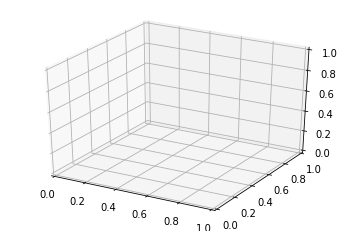

In [63]:
%matplotlib notebook
%matplotlib inline  

# %pylab

def f(aa, bb):
    i=0
    for i in range(len(grandssimNmses)):
      if grandssimNmses[i][1]==aa and grandssimNmses[i][0]==bb:
        break
    return grandssimNmses[i][2]

x = np.asarray([1,5,10,20])
y = np.asarray([1,2,5,10,20,50])

Z = np.zeros((6,4))
X, Y = np.meshgrid(x, y)

for i in range(len(y)):
  for j in range(len(x)):
    Z[i][j] = f(y[i], x[j])

print(Z)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(grandssimNmses[:][0],grandssimNmses[:][1], grandssimNmses[:][2])
ax.set_xlabel('Batch Size')
ax.set_ylabel('Client Iterations')
ax.set_zlabel('SSIM Score')



ax.view_init(9, 120)

plt.show()

In [25]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

In [26]:
print(Z.shape)

(30, 30)
